# Building the model for Savannah

Running this notebook, will create a new SFINCS model 

The following steps are included to create the model:

- Introduction: Add data to the HydroMT datacatalog
- Step 1: Setup the model domain
- Step 2: Initialize and define the model grid
- Step 3: Interpolate elevation data to the model grid
- Step 4: Set model active and boundary cells
- Step 5: Setup subgrid tables
- Step 6: Add forcing to the model
- Step 7: (Optional) Add observation (output) points
- Step 8: Save the model (and create zip archive)
- Step 9: Running the model
- Step 10: Visualize the output data

## Data used
 - Model domain:
    - self-defined polygons
 - Topography & Bathymetry:
    - GEBCO bathymetry
    - Local DEM for Charleston (10m resolution)
 - Waterlevels:
    - GTSM
 - Manning roughness:
    - ESA worldcover (land cover)
    - A reclassification table (reclassify land covert to manning roughness)

## Import dependencies

Excecute to import the needed packages.

In [1]:
# package import
import os
from pathlib import Path
import sys

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd
import hydromt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel

# local script imports
from sfincs_utils import run_sfincs, create_sfincs_model_archive


## Introduction: The hydroMT data catalog

HydroMT uses a data catalog to access and uniformize your data. A data catalog is a *.yml* file with references to external datasets, their metadata, together with some optional basic preprocessing, so the data is already in the correct format when loading it into python. Examples of preprocessing steps are are: renaming of variables, unit conversion using offsets and multiplication, setting missing nodata and CRS metadata.

The `"../data/data_catalog.yml"` file references the data in the data folder.

For constumisation, see the HydroMT documentation for more information on how to [prepare a data catalog](https://deltares.github.io/hydromt/v0.10.0/user_guide/data_prepare_cat.html) and [how to add a raster dataset](https://deltares.github.io/hydromt/v0.10.0/user_guide/data_types.html#rasterdataset). 
**NOTE**: make sure to use the version of the documentation matching your HydroMT installed version (likely v0.10) 

In [2]:
# read the data catalog
data_catalog_file = '..\data\data_catalog.yml'
data_catalog = hydromt.data_catalog.DataCatalog(data_catalog_file)


# view the data catalog
data_catalog.to_dataframe()[
    ["path", "data_type", "driver", "source_url", "source_version"]
]

,path,data_type,driver,source_url,source_version
name,,,,,
MRLC_landcover,c:\Users\sanne\integrated-modelling-in-hydrolo...,RasterDataset,raster,https://www.mrlc.gov/viewer/,NaN
MRLC_landcover_mapping,c:\Users\sanne\integrated-modelling-in-hydrolo...,DataFrame,csv,NaN,NaN
topography_savannah_10m,c:\Users\sanne\integrated-modelling-in-hydrolo...,RasterDataset,raster,NaN,NaN
topography_Savannah_CoNED_G,c:\Users\sanne\integrated-modelling-in-hydrolo...,RasterDataset,raster,NaN,NaN
topography_Savannah_CoNED_SC,c:\Users\sanne\integrated-modelling-in-hydrolo...,RasterDataset,raster,NaN,NaN
osm_landareas,c:\Users\sanne\integrated-modelling-in-hydrolo...,GeoDataFrame,vector,https://osmdata.openstreetmap.de/data/land-pol...,1.0
gebco,c:\Users\sanne\integrated-modelling-in-hydrolo...,RasterDataset,raster,https://download.gebco.net/,2025
gtsm_locations,c:\Users\sanne\integrated-modelling-in-hydrolo...,GeoDataFrame,vector,https://doi.org/10.24381/cds.8c59054f,v1
gtsm_timeseries,c:\Users\sanne\integrated-modelling-in-hydrolo...,DataFrame,csv,https://doi.org/10.24381/cds.8c59054f,v1


## **Step 1:** Setup model domain

In this first step the modelling area is set up as the model domain through a geojson file, located at `../model_domain/model_domain_savannah.geojson`.  

This modelling study is focused on coastal flooding only and hence 
does not include inland boundary locations needed for rainfall contributions to (pluvial) flooding. 

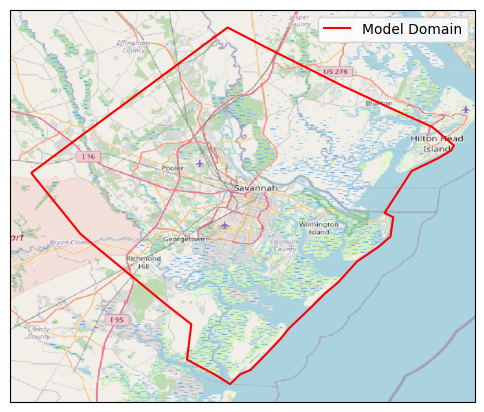

In [3]:
# Read the geojson file containing the model domain
region_fn = Path("../model_domain/model_domain_savannah.geojson")

# Load in initial region of interest using geopandas
region = gpd.read_file(region_fn).to_crs(epsg=4326)

# Plot the region of interest
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.add_image(cimgt.OSM(), 10)
region.boundary.plot(ax=ax, color="red", label="Model Domain")
ax.legend()
plt.show()

## **Step 2:** Initialize and define the model grid

Step 2 contains the initialization and building of the Savannah model.

The following variables need to be specified:
 - `root`: Folder where the model is to be saved. Path is relative to current working directory
 - `mode`: Whether you want to read/append/write the model (to prevent overwriting a model by accident)
 - `data_libs`: One or multiple data catalogs.
 - `logger`: The name of the logger used to keep track of changes to the model

If a model already exists in the root location, it gets overridden by initializing the new model in 'w+' mode. Note that the data catalog is also added with the model initialization

In [4]:
# Specify root_folder and logger_name
# The root_folder is where the model will be stored
root_folder = Path(r"../models/sfincs_savannah")      
logger_name = "SFINCS_log_savannah"
logger = setuplog(
    logger_name, log_level=20
)  # log_level=20 is INFO, more messages are shown with log_level=10 (DEBUG)

# initialize model
sf = SfincsModel(
    root=root_folder,
    mode="w+",  # overwrite mode
    data_libs=[data_catalog_file],
    logger=logger,
)

2026-01-27 12:14:43,165 - SFINCS_log_savannah - log - INFO - HydroMT version: 0.10.1
2026-01-27 12:14:43,225 - SFINCS_log_savannah - data_catalog - INFO - Parsing data catalog from ..\data\data_catalog.yml
2026-01-27 12:14:43,233 - SFINCS_log_savannah - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah\gis.
2026-01-27 12:14:43,234 - SFINCS_log_savannah - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.2.1).


Next we create a model grid by providing our domain and the grid resolution in units given by the crs. By specifying crs="utm", the closest UTM-zone will be used for your model. Any geometries specified in a CRS different than the model CRS will be converted automatically.

Initially the grid will be a rectangle around the provided domain. Later on we will refine this by defining the active cells.

In [5]:
# CHOOSE YOUR MODEL RESOLUTION in the units of the projection (crs)
model_res = 100 # in meters if model_crs is 'utm'

# setup the grid based on the bounding box of the region
sf.setup_grid_from_region(
    region={"geom": region_fn},
    res=model_res,
    rotated=False,  # non-rotated grid.
    crs="utm",  # automatically the closest UTM zone is selected (unit is in meters),
)

# Inspect some grid paramaters:
# shape (mmax x nmax), and resolution in both directions (dx,dy)
print("\nGRID PARAMETERS\n")
print(f'shape: {sf.config["mmax"]}, {sf.config["nmax"]}')
print(f'resolution: {sf.config["dx"]}, {sf.config["dy"]}')
print(f'origin: {sf.config["x0"]}, {sf.config["y0"]}')
print(f'rotation: {sf.config["rotation"]}')
print(f'crs: EPSG:{sf.config["epsg"]}')

2026-01-27 12:14:44,631 - SFINCS_log_savannah - geodataframe - INFO - Reading  vector data from ..\model_domain\model_domain_savannah.geojson

GRID PARAMETERS

shape: 750, 743
resolution: 100, 100
origin: 451456.0, 3508368.0
rotation: 0
crs: EPSG:32617


## **Step 3:** Interpolate elevation data to the grid

`setup_dep()` can be used interpolate elevation data to the grid. This will help to refine the grid later.
Note that this data is not actually used in the model, subgrid tables later on replaces the grid-averaged elevation data.
However, having elevation data on the grid is useful to visualize the terrain and to define active cells in the next step.

It is possible to provide multiple datasets for the elevation data. Each subsequent data set will fill in the gaps in the grid. 
For each dataset, you can optionally set the valid area by providing a minimum or maximum elevation limit `zmin` and `zmax` or geometry `mask`. 
Furthermore, differences in vertical datums between elevation datasets can be corrected by using a uniform or gridded `offset` value which is applied to the dataset.

#### Template for elevation data sources

The data is provided using the template for the `datasets_dep` input below. 
Per source, all arguments except for `elevtn` are optional

```python
datasets_dep = [
    {
        'elevtn': '<elevation data source name>',  # source 1
        'offset': '<offset to vertical datum>',
        'zmin': '<minimum valid elevation value>',
        'zmax': '<maximum valid elevation value>',
    },
    {
        'elevtn': '<elevation data source name>',  # source 2
    }
]
```

In [6]:
# Specify the elevation datasets to use. Note that the names refer to the keys in the data_catalog
# The first dataset is used as the primary elevation source
# The second dataset is used to fill gaps in the first dataset
#TODO add multiple DEM sources
dem_source_1 = "topography_savannah_10m"
dem_source_2 = "topography_Savannah_CoNED_G"
dem_source_3 = "topography_Savannah_CoNED_SC"
dem_source_4 = "gebco"

datasets_dep = [
    {
        "elevtn": dem_source_1, 
        "zmin":0.01
    }, 
    {
        "elevtn": dem_source_2, 
        "zmax":0
    }, 
    {
        "elevtn": dem_source_3, 
        "zmax":0
    },
    {
        "elevtn": dem_source_4,     
        "zmax": 0
    }
]
dep = sf.setup_dep(datasets_dep=datasets_dep, buffer_cells=2)

2026-01-27 12:14:46,363 - SFINCS_log_savannah - rasterdataset - INFO - Reading topography_savannah_10m raster data from c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\data\topography_Savannah_10m.tif
2026-01-27 12:14:46,456 - SFINCS_log_savannah - io - WARNING - nodata value missing for c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\data\topography_Savannah_10m.tif
2026-01-27 12:14:46,509 - SFINCS_log_savannah - rasterdataset - INFO - Reading topography_Savannah_CoNED_G raster data from c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\data\topography_Savannah_CoNED_G.tiff
2026-01-27 12:14:46,553 - SFINCS_log_savannah - rasterdataset - INFO - Reading topography_Savannah_CoNED_SC raster data from c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\data\topography_Savannah_CoNED_SC.tiff
2026-01-27 12:14:46,597 - SFINCS_log_savannah - rasterdataset - INFO - Reading gebco raster data from c:\Users\sanne\integrated-modelling-in-hydrology\2

In [7]:
# note the elevation values are stored in the "dep" variable of the model grid component.
sf.grid

<xarray.Dataset> Size: 2MB
Dimensions:      (x: 750, y: 743)
Coordinates:
  * x            (x) float64 6kB 4.515e+05 4.516e+05 ... 5.263e+05 5.264e+05
  * y            (y) float64 6kB 3.508e+06 3.509e+06 ... 3.583e+06 3.583e+06
    spatial_ref  int64 8B 0
Data variables:
    dep          (y, x) float32 2MB 5.001 5.047 4.935 ... 5.802 0.1696 1.418

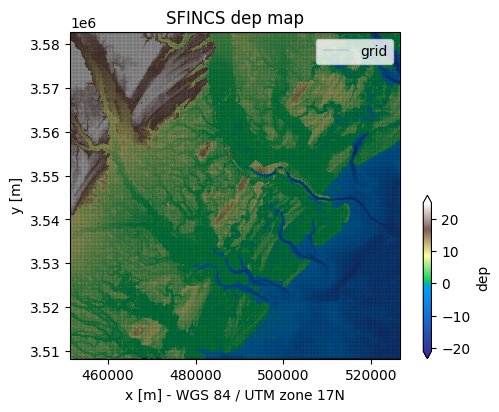

In [8]:
# Plot the elevation on top of the model region and satellite image. The variable argument sets which model variable to plot
fig, ax = sf.plot_basemap(variable="dep", bmap="sat")
sf.grid.raster.vector_grid("lines").plot(ax=ax, color="k", linewidth=0.1, label="grid")
ax.legend()

## **Step 4:** Set active and boundary cells

### Active cells

Next, the grid can be refined by specifying which cells are active by calling the function `setup_mask_active()`. 
Active cells are initialized based on a `mask` geometry. 

Below, define the active cells for your model in two steps. 
In the first step initialize the active cells based on the region geometry `mask` which is used to initialize the grid.
In the second step, further refine it by using additional arguments.

2026-01-27 12:27:13,196 - SFINCS_log_savannah - geodataframe - INFO - Reading  vector data from ..\model_domain\model_domain_savannah.geojson
2026-01-27 12:27:13,324 - SFINCS_log_savannah - regulargrid - INFO - 0 gaps outside valid elevation range < 10.0 km2.
2026-01-27 12:27:13,331 - SFINCS_log_savannah - sfincs - INFO - Derive region geometry based on active cells.
2026-01-27 12:27:13,356 - SFINCS_log_savannah - model_api - WARNING - Replacing geom: region
Active cells:  <xarray.DataArray 'msk' ()> Size: 8B
array(286686)
Coordinates:
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  0


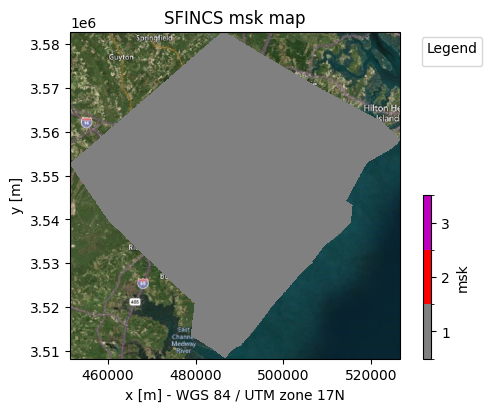

In [9]:
# Set the mask based on the region mask
sf.setup_mask_active(
    mask=region_fn,  # Path to the mask file, commonly the region of interest
    reset_mask=True,   # to start with a clean mask
)

# Plot the mask. Using variable='msk' will display the mask values for the active cells.
_ = sf.plot_basemap(variable="msk", bmap="sat")

# how many active cells are in the model
active_cells = np.sum(sf.mask == 1)
print("Active cells: ", active_cells)


### Improving the mask

If you are not satisfied with the initial active mask you created, you can either modify the geometry file you used in e.g. QGIS or use the additional arguments of the `setup_mask_active()` function to refine it as shown below.

You can refine your mask using the a minimum `zmin` and maximum height `zmax` arguments.
Furthermore, he active cells can be refined by adding areas inside the `include_mask` geometries, or removing areas inside the `exclude_mask` geometries. 
Small groups of isolated cells can be removed with the `drop_area` argument while holes in the mask can be filled with the `fill_area` argument. 
If `reset_mask=True` to existing mask is re-initialized and previous edits are overwritten. 
Be mindful of this setting in case you define active cells with multiple calls of `setup_mask_active()`.

You can draw include and exclude geometries in e.g. http://geojson.io or QGIS and export to geojson to use here. 
If you want draw these geometries on top of the existing mask you can export it to geotiff using `sf.grid["msk"].raster.to_raster("path/to/mask.tif")` and load in QGIS.

Find more information about the function `setup_mask_active()` [in the docs](https://deltares.github.io/hydromt_sfincs/stable/_generated/hydromt_sfincs.SfincsModel.setup_mask_active.html)


In [10]:
# Include mask and exclude mask polygons:
#zmin_active = None
#zmax_active = None
#include_mask_filename = "Path('../model_domain/include_mask.geojson')"  #remove string quotations
#exclude_mask_filename = "Path('../model_domain/YOUR_EXCLUDE_MASK')"     #remove string quotations
#drop_area = None
#fill_area = None

# Run function:
# comment out a line if you don't use the include mask, exclude mask, drop area or fill area
#sf.setup_mask_active(
    # zmin=zmin_active,  # Minimum elevation [m] to set as active
    # zmax=zmax_active,  # Maximum elevation [m] to set as active
    # include_mask=include_mask_filename,
    # exclude_mask=exclude_mask_filename,
    # drop_area=drop_area,
    # fill_area=fill_area,
#    reset_mask=False  
# )

# Plot the mask. Using variable='msk' will display the mask values for the active cells.
#_ = sf.plot_basemap(variable="msk", bmap="sat")

### Boundary cells

The boundaries function by default as hard walls, allowing no flow in or out. The boundaries on *downstream* open water boundaries can be used to force the water levels there. We can do this by calling `setup_mask_bounds()`. Setting `btype="waterlevel"` will specify waterlevel boundaries (msk=2). Boundary cells can be selected similarly to the active cells, by providing elevation limits `zmax` (i.e. all boundary cells below this elevation will set as waterlevel boundary) and/or using `include_mask` and `exclude_mask`.

If significant flow to outside of the model is expected to occur at some boundaries, these boundaries can be set as outflow boundaries by setting `btype="outflow"` providing the geometry of the desired bounds. This is usually only necessary when applying rainfall to the grit. For stability, avoid outflow boundaries adjacent to waterlevel boundaries.  

Find more information about the function `setup_mask_bounds()` [in the docs](https://deltares.github.io/hydromt_sfincs/stable/_generated/hydromt_sfincs.SfincsModel.setup_mask_bounds.html)

2026-01-27 12:27:18,172 - SFINCS_log_savannah - geodataframe - INFO - Reading  vector data from ..\model_domain\Savannah_waterlevel_msk_v3.geojson


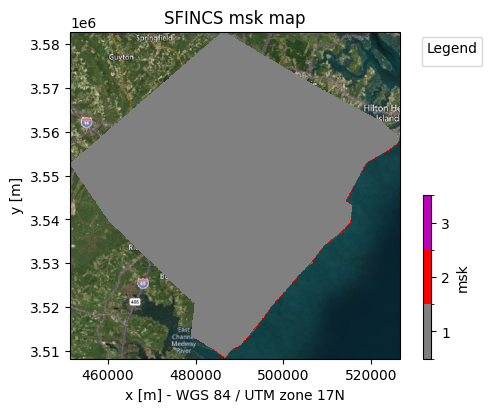

In [11]:
# Setup water level bounds

# use either on of the following options:
#zmax_bounds = 3
waterlevel_mask_filename = Path('../model_domain/Savannah_waterlevel_msk_v3.geojson')  #TODO fill with own file

# comment out a line to ignore the argument
sf.setup_mask_bounds(
    btype="waterlevel",
    #zmax=zmax_bounds,          # Maximum elevation of boundary cells [m] to assign as waterlevel boundary
    include_mask=waterlevel_mask_filename,  # mask of boundary cells to assign as waterlevel boundary
    reset_bounds=True,
)

# Inspect the updated mask. Mask value 2 means waterlevel boundary, mask value 3 means outflow boundary
_ = sf.plot_basemap(variable="msk", bmap="sat", plot_bounds=False)

## **Step 5:** Setup subgrid tables

By pre-calculating lookup tables that account for the subgrid variation in bedlevels and friction, the computation can be executed at a courser resolution (i.e. the model grid) without loosing much accuracy up to a certain resolution. 
The lookup tables contain storage and conveyance capacity levels for (usually ~15) different water levels. 
At computation the cell storage and conveyance capacity to neighboring cells is estimated by interpolating the information from these tables. 
The subgrid approach assumes a uniform water level within the entire model grid cell. Hence on steep terrain this assumption might not be valid. 

The subgrid tables require both the elevation `datasets_dep`, as specified in step 3, and roughness datasets `datasets_rgh` as shown below.
Furthermore, the subgrid resolution `nr_subgrid_pixels` needs to be specified as a ratio of the model grid resolution (i.e. 10 means 10x finer subgrid resolution).
The number of levels `nlevels` at which the subgrid variation is described can be specified. More levels usually lead to more accurate results, but also increase the model setup time and size of the model files.
For the computation of the subgrid tables, the maximum number of subgrid pixels per calculation block `nrmax` needs to be specified. Decrease this value if you run into memory errors during model setup.
For other options of the `setup_subgrid()` function see the [docs](https://deltares.github.io/hydromt_sfincs/stable/_generated/hydromt_sfincs.SfincsModel.setup_subgrid.html).

Reference paper: https://gmd.copernicus.org/articles/18/843/2025/ 



### Define model **surface roughness** data

We can specify the surface roughness to better characterize the water flow on open surfaces. When we don't specify anything defaults values for the manning roughness are used based on elevation thresholds. We can specify manning roughness values ourselves, or we can provide a dataset with landuse classes. These classes are then converted to roughness values using a reclassification table. Here, it is also possible to provide multiple datasets to fill in any gaps that might exist in the previous datasets, similar to the elevation. 

In this example we will use the ESA worldcover land use dataset together with a reclass table which maps each landuse class to a specific manning roughness value, see below how such table should look like. Both are called with the proper entry name from the data catalog. We recommend using more detailed local datasources if those are available. 

#### example reclass table to map landuse to roughness values (N)
| class | description               | N     |
|-------|---------------------------|-------|
| 10    | Tree cover                | 0.12  |
| 20    | Shrubland                 | 0.05  |
| 30    | Grasland                  | 0.034 |
| ..    | ........                  | ..... |
| 0     | No data                   | -999  |

#### Template for roughness data sources

The data is provided using the template for the `datasets_rgh` input below. 
Per source, the `lulc` and `reclass_table` fields are required.

```python
datasets_rgh = [
    {
        "lulc": <landuse/landcover source name>,  # source 1
        "reclass_table": <reclassification table source name>,  
    },
    {
        "lulc": <landuse/landcover source name>,  # source 2
        "reclass_table": <reclassification table source name>,  
    }
]
```

In [12]:
# Specify the surface roughness datasets to use. Note that the names refer to the keys in the data_catalog
# Here we use the ESA worldcover landuse dataset together with a reclass table which maps each landuse class to a specific manning roughness value
datasets_rgh = [
    {
        "lulc": "MRLC_landcover",  # landuse/landcover dataset      #TODO fill with own data
        "reclass_table": "MRLC_landcover_mapping",  # reclassification table
    }
]

### Define model subgrid elevation

See step 3 for defining elevation data sources. You may use the same elevation datasets as in step 3 or different ones if you have higher resolution data available for your model domain.
In case of the latter, redefine the `datasets_dep` variable accordingly.

In [13]:
# specify the subgrid resolution as a ratio of the model grid (i.e. 10 means 10x finer subgrid resolution)
# select a value that is appropriate based on your model grid resolution and the resolution of the available high resolution topography data
# To avoid running into memory errors, use a subgrid resolution of at least 10 meters. 
nr_subgrid_pixels = 2 # becasue DEM is 100m 

# NOTE: this step can take some time (~minutes)
sf.setup_subgrid(
    datasets_dep=datasets_dep,  # elevation datasets, same as step 3
    datasets_rgh=datasets_rgh,  # roughness datasets, same as step 4
    nlevels=15,  # number of levels at which the subgrid variotion is described
    nr_subgrid_pixels=nr_subgrid_pixels,  # subgrid resolution as ratio of model grid (i.e. 10 means 10x finer subgrid resolution)
    nrmax=4000,  # maximum number of subgrid pixels per calculation block (decrease if memory errors occur)
    write_dep_tif=True,  # write subgrid elevation to tif
)

2026-01-27 12:27:22,323 - SFINCS_log_savannah - rasterdataset - INFO - Reading topography_savannah_10m raster data from c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\data\topography_Savannah_10m.tif
2026-01-27 12:27:22,351 - SFINCS_log_savannah - io - WARNING - nodata value missing for c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\data\topography_Savannah_10m.tif
2026-01-27 12:27:22,368 - SFINCS_log_savannah - rasterdataset - INFO - Reading topography_Savannah_CoNED_G raster data from c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\data\topography_Savannah_CoNED_G.tiff
2026-01-27 12:27:22,395 - SFINCS_log_savannah - rasterdataset - INFO - Reading topography_Savannah_CoNED_SC raster data from c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\data\topography_Savannah_CoNED_SC.tiff
2026-01-27 12:27:22,427 - SFINCS_log_savannah - rasterdataset - INFO - Reading gebco raster data from c:\Users\sanne\integrated-modelling-in-hydrology\2

The nodata value None is not in the reclass table.None will be used for the params.


2026-01-27 12:27:22,728 - SFINCS_log_savannah - subgrid - INFO - Number of regular cells in a block : 2000
2026-01-27 12:27:22,729 - SFINCS_log_savannah - subgrid - INFO - Number of blocks in n direction    : 1
2026-01-27 12:27:22,730 - SFINCS_log_savannah - subgrid - INFO - Number of blocks in m direction    : 1
2026-01-27 12:27:22,731 - SFINCS_log_savannah - subgrid - INFO - Grid size of flux grid            : dx=100.0, dy=100.0
2026-01-27 12:27:22,732 - SFINCS_log_savannah - subgrid - INFO - Grid size of subgrid pixels       : dx=50.0, dy=50.0
2026-01-27 12:27:22,732 - SFINCS_log_savannah - subgrid - INFO - block 1/1 -- col 0:749 | row 0:742
2026-01-27 12:48:50,285 - SFINCS_log_savannah - subgrid - WARNING - Interpolate elevation data at 12630 subgrid pixels
2026-01-27 12:48:52,851 - SFINCS_log_savannah - subgrid - WARNING - Fill manning roughness data at 596 subgrid pixels with default values
2026-01-27 12:49:19,476 - SFINCS_log_savannah - utils - INFO - Building 3 overviews with a

## **Step 6:** Add Forcing

Next we configure the forcing, the data we use as input in the model. SFINCS forcings include water levels at the waterlevel boundaries, river discharges at source points, rainfall, wind and pressure. For this example where we simulate coastal flooding, we only use water level boundaries. First, we need to set a time window to simulate. In subsequent steps to setup the forcing data will only be saved for this time period. 

Look on the internet when a large flood event happened in Charleston in 2016 (we only have forcing data for October 2016 prepared) and use this event for your model by setting the start time `tstart` and end time `tend`, the reference time `tref` is usually also set to the start time. 2 days of simulation around the event should be sufficient. In addition we set the output time resolution at which gridded normal and max outputs are saved in *sfincs_map.nc* using `dtout` and `dtmaxout`, and the time resolution at which timeseries outputs are saved in *sfincs_his.nc* `dthisout`. Note that this is not the computational time step which is adaptive and calculated based on the courant number. Finally, you should set a uniform initial water level at all active cells `zsini`. Be cautious to not set this value too high to avoid initializing the model with flooding. You can set update more model settings in this step, for a full overview see [sfincs docs](https://sfincs.readthedocs.io/en/latest/parameters.html)


In [14]:
# Specify the simulation time in the model config
model_time_config = {
    "tref": "20161005 000000", #FILL IN THE REFERENCE TIME (can be any date)    #TODO pick a date
    "tstart": "20161007 000000", #FILL IN THE START TIME OF THE SIMULATION
    "tstop": "20161012 230000", #FILL IN THE END TIME OF THE SIMULATION
    "dtout": 3600, # [sec] FILL IN THE TIMESTEP OF THE MAP OUTPUT
    "dtmaxout": 86400, # [sec] FILL IN THE TIMESTEP OF THE MAXIMUM MAP OUTPUT
    "dthisout" : 3600, # [sec] FILL IN THE TIMESTEP OF THE SCALAR OUTPUT
    "zsini": -0.5, # [m] FILL IN THE INITIAL WATERLEVEL
}

sf.setup_config(**model_time_config)

### Water level forcing

For the forcing of the water levels at the boundary we use the Global Tide and Surge Model (GTSM). This includes hourly waterlevels at predetermined points. 
To get the waterlevels at our boundary we interpolate these points to our boundary when we read in the data. 

Check the `gtsm_locations` and `gtsm_timeseries` files. You can find the file locations in the data catalog.
Note that the index attribute of the locations matches with the column names of the timeseries file. This is important for HydroMT to know which timeseries belongs to which location!

In [16]:
# change to locations and timeseriesa
sf.setup_waterlevel_forcing(
    locations="gtsm_locations",
    timeseries="gtsm_timeseries",
    merge=False,  # do not merge with existing locations and timeseries
    # use a large buffer to include all points if the following error is raised
    # ValueError: The gdf_locs index and df_ts columns must be the same
    buffer=1e5,  # buffer from model boundary [m]; exclude points outside the buffer
)

2026-01-27 12:54:00,419 - SFINCS_log_savannah - dataframe - INFO - Reading gtsm_timeseries csv data from c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\data\gtsm_codec_reanalysis_hourly_v1\validationtimeseries.csv


2026-01-27 12:54:00,425 - SFINCS_log_savannah - geodataframe - INFO - Reading gtsm_locations vector data from c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\data\gtsm_codec_reanalysis_hourly_v1\gauging_location.geojson
2026-01-27 12:54:00,508 - SFINCS_log_savannah - sfincs - INFO - Setting gdf_locs index to id


dict_keys(['bzs'])


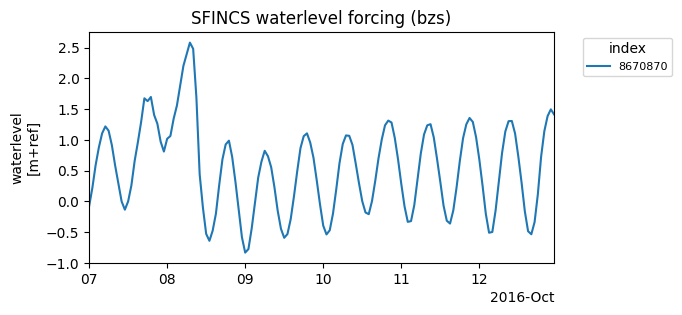

In [17]:
# The keys to access the model forcing
print(sf.forcing.keys())

# Plot the forcing
_ = sf.plot_forcing()

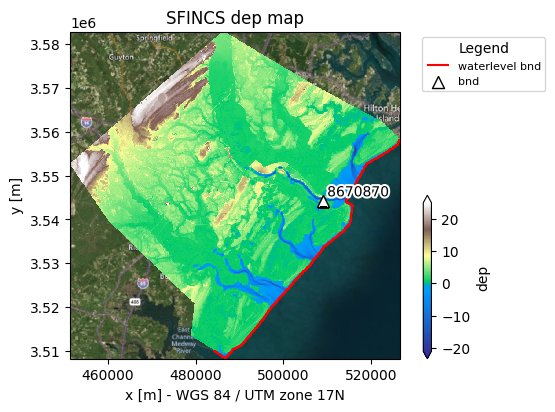

In [18]:
# Plot model summary so far, showing the GTSM points used for the waterlevel forcing
_ = sf.plot_basemap(variable="dep", bmap="sat")

## **Step 7:** Observation points and lines (BONUS)

The final output of the model will generally not be stored with the same temporal resolution the model uses during calculations to keep the output size in check. We can however specify some points and lines, called observation points and lines for which the model outputs are tracked with the higher temporal resolution. Observation points track the water level, while observation lines track the flow volumes passing through that line. These timeseries outputs will be saved in *sfincs_his.nc*

The geometry of the observation points and lines are  provided as geojson files. In our exercise we will only add observation points.
Create your own geojson by going to http://geojson.io and create observation points in SFINCS. 
To do so we use the `setup_observation_points` function, calling the geojson that you made.

For more information about this function the [docs](https://deltares.github.io/hydromt_sfincs/stable/_generated/hydromt_sfincs.SfincsModel.setup_observation_points.html).

In [19]:
# Path to observation points & lines geometries
# obs_to_remove = ["obs0", "obs1"]
# obs_points_json = (gpd.read_file("../model_domain/obs_points_savannah.geojson").to_crs(epsg=4326))
# obs_points_json = obs_points_json[~obs_points_json["obs #"].isin(obs_to_remove)]
# obs_points_json.to_file("../model_domain/obs_points_savannah_filtered.geojson", driver="GeoJSON")

obs_points_fn = Path(r"../model_domain/obs_points_savannah_irma.geojson")

# Setup observation. merge argument handles whether to override or not
sf.setup_observation_points(locations=obs_points_fn, merge=False)

# Print the keys to access the observation geometries
sf.geoms.keys()

2026-01-27 12:54:21,439 - SFINCS_log_savannah - geodataframe - INFO - Reading  vector data from ..\model_domain\obs_points_savannah_irma.geojson


dict_keys(['region', 'obs'])

Finally we plot a summary of our model. This shows the boundary used as waterlevel, the points in the GTSM data used for the waterlevel forcing, and the observation points and lines.

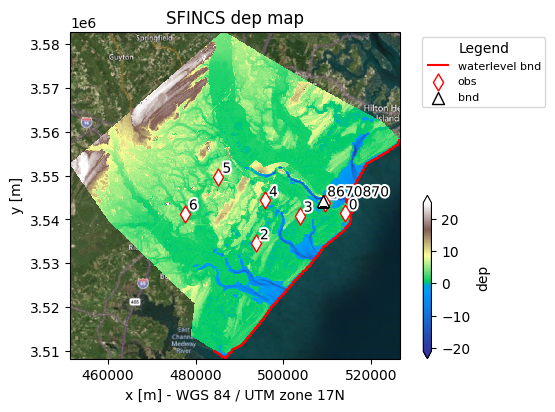

In [20]:
_ = sf.plot_basemap(variable="dep", bmap="sat")

## **Step 8:** Save model

Before running the model you need to save it. You can also update and finetune it later by reading it back in append mode. Fill in the cell below to save your model:

In [21]:
# SAVE YOUR MODEL:
sf.write()

2026-01-27 12:54:25,021 - SFINCS_log_savannah - sfincs - INFO - Writing model data to c:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah
2026-01-27 12:54:25,029 - SFINCS_log_savannah - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2026-01-27 12:54:28,084 - SFINCS_log_savannah - sfincs - INFO - Write geom files
2026-01-27 12:54:28,089 - SFINCS_log_savannah - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2026-01-27 12:54:28,132 - SFINCS_log_savannah - sfincs - INFO - Write forcing files
2026-01-27 12:54:28,146 - SFINCS_log_savannah - sfincs - INFO - Write vector file(s) for forcing.bzs to 'gis' subfolder
2026-01-27 12:54:28,154 - SFINCS_log_savannah - sfincs - WARNING - zsini not in states, skipping


Saving the model will create a standard folder structure to be used when reading a model in. 
Note that the files in the GIS folder are not used by the model, but are useful for visualisation purposes.
This folder structure can be inspected with the code below or by looking at the folder structure in your file explorer:

In [22]:
def print_directory_tree(directory):
    for root, _, files in os.walk(directory):
        level = root.replace(directory, "").count(os.sep)
        indent = " " * 2 * (level)
        print("{}{}/".format(indent, os.path.basename(root)))
        subindent = " " * 2 * (level + 1)
        for f in files:
            print(f"{subindent}+ {f}")


print_directory_tree(sf.root)

sfincs_savannah/
  + hmax.tif
  + hydromt.log
  + sfincs.bnd
  + sfincs.bzs
  + sfincs.ind
  + sfincs.inp
  + sfincs.msk
  + sfincs.obs
  + sfincs_his.nc
  + sfincs_log.txt
  + sfincs_map.nc
  + sfincs_model.zip
  + sfincs_subgrid.nc
  figs/
    + hmax.png
  gis/
    + bnd.geojson
    + dep.tif
    + msk.tif
    + obs.geojson
    + region.geojson
  subgrid/
    + dep_subgrid.tif


### create a zip archive of the model

Note this can be used to submit your model on canvas.

In [23]:
# NOTE: the depfile and manningfile are not written to disk if a subgrid table is present, you may ignore this warning

create_sfincs_model_archive(
    sfincs_inp=Path(sf.root, "sfincs.inp"),
    zip_filename=Path(sf.root, "sfincs_model.zip"),
)

WindowsPath('c:/Users/sanne/integrated-modelling-in-hydrology/2_flood_risk/models/sfincs_savannah/sfincs_model.zip')

## **Step 9:** Run your model
We have now set up our own SFINCS model for Charleston, well done! We are now ready to run the model. 
For more infor see notebook `1_run_your_first_model.ipynb`

In [24]:
# NOTE you need to download the SFINCS executable first (see first notebook) and update the path below
sfincs_exe = Path("../software", "sfincs_v2.1.1", "sfincs.exe")

run_sfincs(
    Path(root_folder, "sfincs.inp"),  # path to the SFINCS model root folder
    run_method="exe",  # run SFINCS using the executable, other options are "docker" or "singularity"
    sfincs_exe=sfincs_exe,  # path to the sfincs executable if you want to run SFINCS on windows
)

Running SFINCS model in C:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\models\sfincs_savannah with command:
>> C:\Users\sanne\integrated-modelling-in-hydrology\2_flood_risk\software\sfincs_v2.1.1\sfincs.exe

 -----------------------------------------

 Build-Revision: $Rev: v2.1.1-Dollerup
 Build-Date:     $Date: 2024-08-28

 Reading input file ...
 Info : Running SFINCS in subgrid mode ...
 Turning on process: Viscosity
 Advection scheme : First-order upwind
 Reading meteo data ...
 Info : Preparing SFINCS grid on regular mesh ...
 Reading index file : sfincs.ind ...
 Reading mask file : sfincs.msk ...
 Number of active z points    :       286686
 Number of active u/v points  :       571856
 Viscosity - nuvisc  =    1.000000    
 Reading sub-grid netCDF file ...
 Number of subgrid levels :           15
 Reading water level boundaries ...
 Reading observation points ...
 Initializing output ...

 ---------- Starting simulation ----------
 ---- Using 24 of 24 available th

## **Step 10:** Inspecting the results: floodmap
Inspect the results of the model run by plotting the maximum water depths on a map. 
In order to do so you should first read the results of the model (*sf.read_results()*). 
After this you can access the results by using the results attribute: *sf.results*.
The results you can plot using matplotlib.

*Tip: Print all available result keys by typing `print(sf.results.keys())`*  
*Tip:* You can also plot the results on top of the SFINCS basemap

In [25]:
# hmax is computed by SFINCS and read-in from the sfincs_map.nc file
sf.read_results()

Text(0.5, 1.0, 'SFINCS maximum water depth')

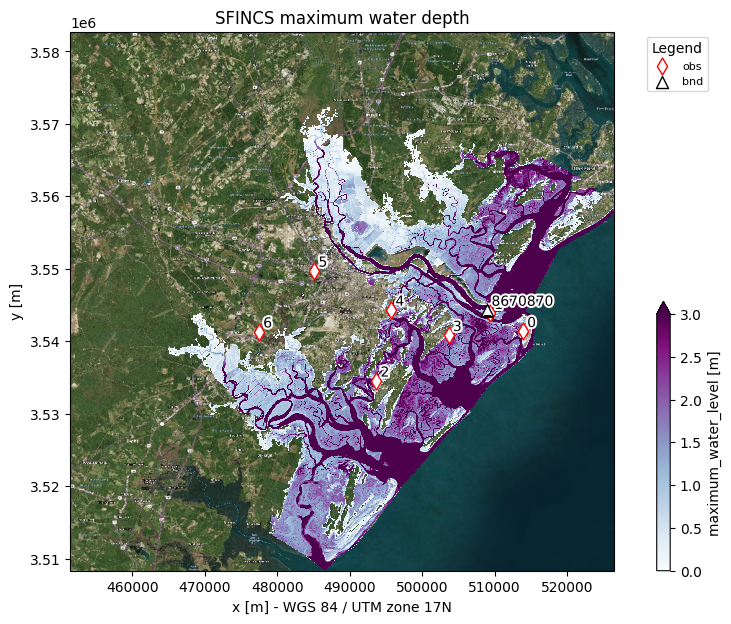

In [26]:
# We use the subgrid resolution topography to downscale the maximum water level to water depth at the subgrid resolution
# First, we read the subgrid resolution topography and check if the file exists
dep_subgrid_file = Path(root_folder, "subgrid", "dep_subgrid.tif")  
dep_subgrid = hydromt.open_raster(dep_subgrid_file, nodata=np.nan) # elevation at subgrid resolution

# calculate the maximum water depth (hmax) as the difference between 
# the maximum water level (zsmax) and the elevation (dep)
zsmax = sf.results["zsmax"].max(dim="timemax") # maximum water level
zsmax_subgrid = zsmax.raster.reproject_like(dep_subgrid, method="nearest")  # reproject to subgrid resolution
hmax_subgrid = np.maximum(0, zsmax_subgrid - dep_subgrid).round(2).astype(np.float32) # maximum water depth
# Here, we assume that all areas with a negative depth are permanent water bodies
# This is a strong simplification. It is better to use a more sophisticated approach
# to identify permanent water bodies, e.g. based on a water mask or a "tide-only" simulation.
######################################################################################################### Comment In #################
# permament_water = dep_subgrid < 0 
# hmax_subgrid = hmax_subgrid.where(~permament_water, np.nan) # mask areas with permanent water
#######################################################################################################################################
# update (geospatial) metadata
hmax_subgrid.raster.set_crs(dep_subgrid.raster.crs)
hmax_subgrid.raster.set_nodata(np.nan)
hmax_subgrid.name = "max water depth"
hmax_subgrid.attrs["units"] = "m"

fig, ax = sf.plot_basemap(
    fn_out="hmax.png",  # save figure to mod.root/figs/hmax.png
    variable=hmax_subgrid,
    plot_bounds=False,
    bmap="sat",
    zoomlevel=12,
    figsize=(11, 7),
    vmin=0,  # set minimum value for colorbar
    vmax=3,  # set maximum value for colorbar
    cmap="BuPu",
)
ax.set_title("SFINCS maximum water depth")


In [27]:
# save the results to a geotiff file
# round to 2 decimals to reduce file size

hmax_subgrid.raster.set_nodata(np.nan)
hmax_subgrid.round(2).raster.to_raster(
    Path(sf.root, "hmax.tif"),
    compress="lzw",
    overwrite=True,
    dtype="float32",
)

In [28]:
# Compare modelled maxima to the maxima from the observation points
obs_points = gpd.read_file("../model_domain/obs_points_savannah_irma.geojson").to_crs(epsg=4326)
obs_points = obs_points.set_index("obs #")
obs_values = pd.read_csv("../model_domain/irma_observation_locations.csv")
obs_values = obs_values.set_index("obs #")
obs_values = obs_values[["Val"]]

sampled_values = hmax_subgrid.raster.sample(obs_points)
obs_points['Simulated_Hmax'] = sampled_values

obs_points_vals = obs_points.join(obs_values)

# select_obs_points = obs_points[~obs_points["obs #"].isin([obs_to_remove])]

fig, ax = plt.subplots()
fig.suptitle("Maximum Water Height for Observation Points")

ax.bar(obs_points_vals.index, obs_points_vals.Simulated_Hmax, alpha=0.7, color="orange", label="Modelled", zorder=5)
ax.bar(obs_points_vals.index, obs_points_vals.Val, alpha=0.7, color="gray", label="Observed", zorder=3)

obs_points_vals["nans"] = np.where(obs_points_vals.Simulated_Hmax.isna(), 0, np.nan)
ax.scatter(obs_points_vals.index, obs_points_vals.nans, color="red", label="NaN Modelled", zorder=6)

ax.grid(color="lightgray", alpha=0.3, zorder=0)
ax.set_title("Observed vs. Modelled")
ax.set_xlabel("Observation point on map")
ax.set_ylabel("Maximum water height [m]")
ax.legend()

plt.plot()

ValueError: columns overlap but no suffix specified: Index(['Val'], dtype='object')

In [ ]:
# tmax = sf.results["tmax"]

# # Als je dit wilt plotten zoals je flood map:
# tmax_subgrid = tmax.raster.reproject_like(dep_subgrid, method="nearest")

# # Of bekijk de waarde voor je observatiepunten
# tmax_points = tmax.raster.sample(obs_points)
# print(tmax_points)

# sf.results["timemax"]

## **What's Next:** Updating your model boundary conditions

Well done, you created your own SFINCS model! 